In [1]:
import string
import random
from random import randint
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
from scipy import ndimage 
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

2023-04-01 10:28:59.826781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-04-01 10:28:59.826830: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Part 1: Test generating single letter

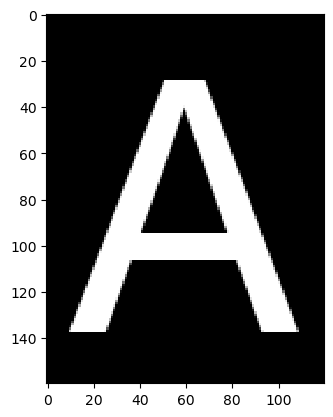

In [2]:
zeros = np.zeros(shape=(160,120), dtype=np.uint8)
# plt.imshow(zeros)
image = Image.fromarray(zeros)
draw = ImageDraw.Draw(image)
font = ImageFont.truetype(r"/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 165)
text = "A"
draw.text(xy=(10,0), text=text, font=font, fill=255)

letter_image = np.array(image)
plt.imshow(letter_image, cmap='gray')

## 1.2 Dict from Character -> Index

In [3]:
chars = list(string.ascii_uppercase + string.digits)
ctoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for i,c in enumerate(chars)}
print(ctoi)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


# Part 2: Generate list of image of each character

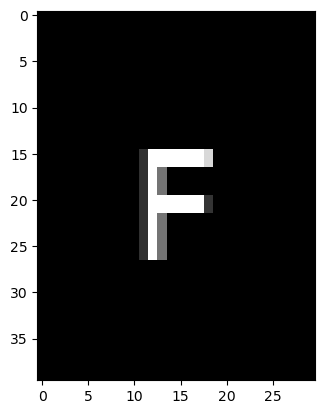

In [4]:
letter_images = []

FONT_HEIGHT = 20


for i in range(36):
    zeros = np.zeros(shape=(int(FONT_HEIGHT * 2), int(FONT_HEIGHT * 1.5)), dtype=np.uint8)
    # plt.imshow(zeros)
    image = Image.fromarray(zeros)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(r"/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf", FONT_HEIGHT)
    text = itoc[i]
    # print(font.getsize(text))
    draw.text(xy=(FONT_HEIGHT*0.5,FONT_HEIGHT*0.5), text=text, font=font, fill=255)
    letter_image = np.array(image)
    letter_images.append(letter_image)

letter_images = np.stack([ im for im in letter_images], axis=0)
letter_images.shape

# show random one
plt.imshow(letter_images[np.random.randint(36)], cmap='gray')

## 2.2: Rotate images

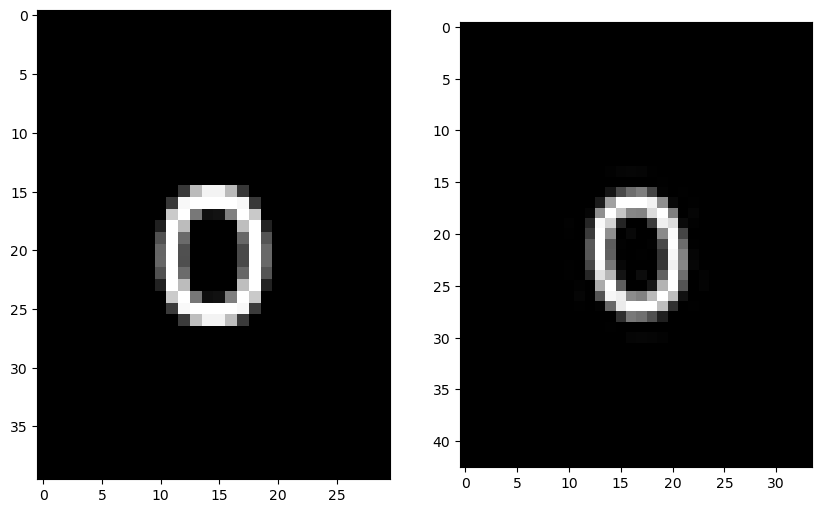

In [5]:
image = letter_images[np.random.randint(0,36)]
rotated = ndimage.interpolation.rotate(image, np.random.randint(-20,20), axes=(0,1), reshape=True)
# show random one 
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(rotated, cmap='gray')

## 2.3: Shift images

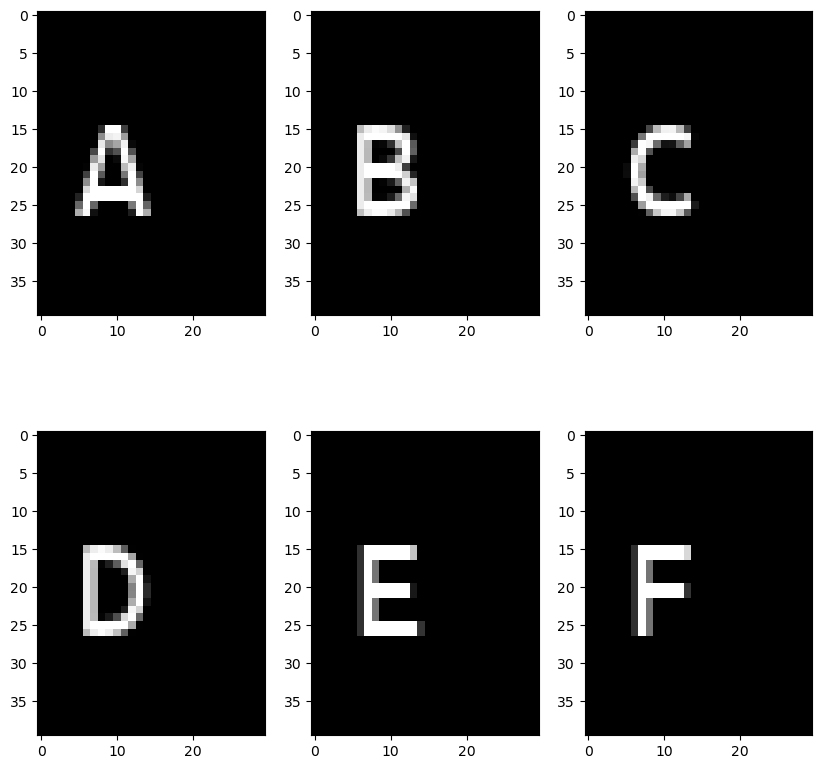

In [6]:
def shift_image_batch(X, dx_range, dy_range):
    out = X.copy()
    dx = np.random.randint(-dx_range, dx_range)
    dy = np.random.randint(-dy_range, dy_range)
    out = np.roll(X, dy, axis=1)
    out = np.roll(X, dx, axis=2)
    if dy>0:
        out[:,:dy, :] = 0
    elif dy<0:
        out[:,dy:, :] = 0
    if dx>0:
        out[:, :, :dx] = 0
    elif dx<0:
        out[:, :, dx:] = 0
    return out



SHIFT_RANGE = 5

fig, axs = plt.subplots(2, 3, figsize=(10, 10)) 
shifted = shift_image_batch(letter_images[:6].copy(), SHIFT_RANGE, SHIFT_RANGE)
for i in range(6):
    axs[i//3, i%3].imshow(shifted[i], cmap='gray')

## 2.4 Perspective Transform

In [7]:
def unit_rand():
    return np.random.rand() * 2 - 1

[[ 1.10637355 -0.05400926  0.25834984]
 [ 0.10984458  0.87983596 -0.26465929]
 [ 0.02002174 -0.01679095  1.        ]]


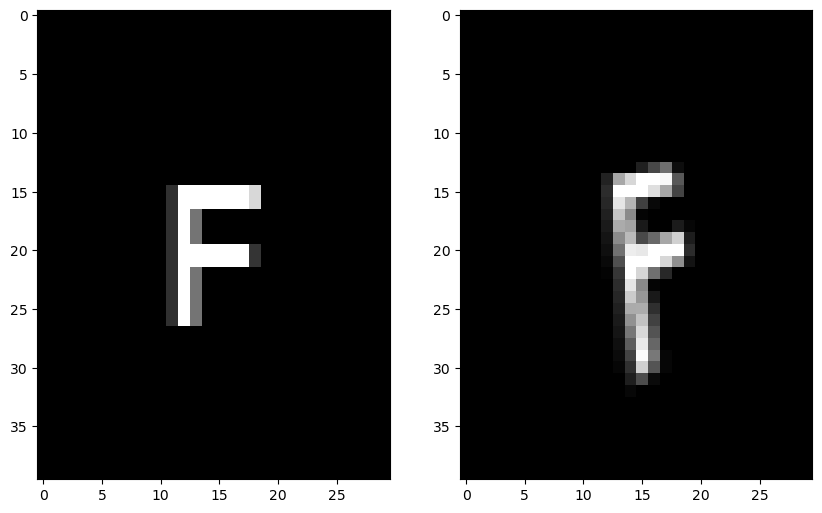

In [8]:
# Locate points of the documents
    # or object which you want to transform
image = letter_images[np.random.randint(0,36)]

RAND_RANGE = 0.8

pts1 = np.float32([[0, 0], [10, 0], [0, 10], [10, 10]])
pts2 = np.float32([[x + RAND_RANGE*unit_rand(), y + RAND_RANGE*unit_rand()] for x, y in pts1])
# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(pts1, pts2)
print(matrix)
result = cv2.warpPerspective(image, matrix, image.T.shape, flags=cv2.INTER_LINEAR)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(result, cmap='gray')

# Part 3: Batch-ify it

In [9]:
RAND_RANGE = 0.8

X = letter_images.copy()
Y = tf.one_hot(np.arange(36), depth=36)

for i in range(1000):
    # shifted = shift_image_batch(letter_images, SHIFT_RANGE, SHIFT_RANGE)
    rotated = ndimage.interpolation.rotate(letter_images, np.random.randint(-20,20), axes=(1,2), reshape=False)
    results = []
    for j in range(36):
        pts1 = np.float32([[0, 0], [10, 0], [0, 10], [10, 10]])
        pts2 = np.float32([[x + RAND_RANGE*unit_rand(), y + RAND_RANGE*unit_rand()] for x, y in pts1])
        # Apply Perspective Transform Algorithm
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        result = cv2.warpPerspective(rotated[j], matrix, rotated[j].T.shape, flags=cv2.INTER_LINEAR)
        contours, hierarchy = cv2.findContours(result, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        x,y,w,h = cv2.boundingRect(max(contours, key = cv2.contourArea))
        result = cv2.resize(result[y:y+h, x:x+w], result.T.shape)
        results.append(result)

    results = np.stack([ im for im in results], axis=0)
    labels = tf.one_hot(np.arange(36), depth=36)

    X = np.append(X, results, axis=0)
    Y = np.append(Y, labels, axis=0)
X.shape, Y.shape

2023-04-01 10:29:09.848153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 10:29:09.848425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-04-01 10:29:09.848491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-04-01 10:29:09.848546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libra

((36036, 40, 30), (36036, 36))

## 3.1 Sample randomly to validate labels

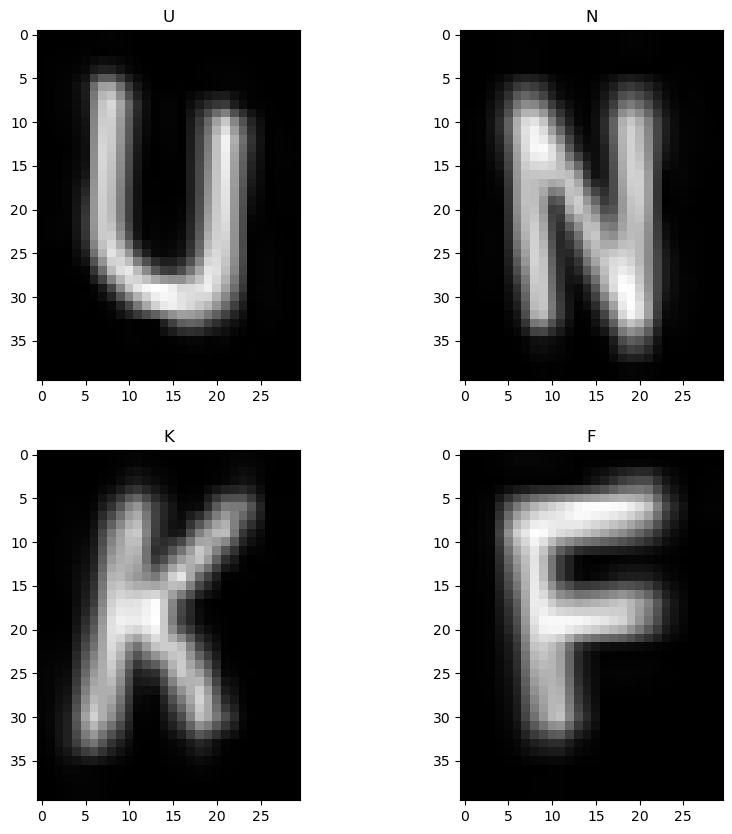

In [10]:
fig, axs = plt.subplots(2,2 , figsize=(10, 10))
for i in range(4):
    N = X.shape[0]
    n = np.random.randint(N)
    axs[i//2, i%2].imshow(X[n], cmap='gray')
    axs[i//2, i%2].set_title(itoc[np.argmax(Y[n])])


## 3.2: Data split

In [11]:
train_split = 0.9
N = X.shape[0]
n = int (N * train_split)
X_train = X[:n]
Y_train = Y[:n]
X_valid = X[n:]
Y_valid = Y[n:]

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(32432, 40, 30)
(32432, 36)
(3604, 40, 30)
(3604, 36)


[Text(0, 0, 'A'),
 Text(0, 0, 'B'),
 Text(0, 0, 'C'),
 Text(0, 0, 'D'),
 Text(0, 0, 'E'),
 Text(0, 0, 'F'),
 Text(0, 0, 'G'),
 Text(0, 0, 'H'),
 Text(0, 0, 'I'),
 Text(0, 0, 'J'),
 Text(0, 0, 'K'),
 Text(0, 0, 'L'),
 Text(0, 0, 'M'),
 Text(0, 0, 'N'),
 Text(0, 0, 'O'),
 Text(0, 0, 'P'),
 Text(0, 0, 'Q'),
 Text(0, 0, 'R'),
 Text(0, 0, 'S'),
 Text(0, 0, 'T'),
 Text(0, 0, 'U'),
 Text(0, 0, 'V'),
 Text(0, 0, 'W'),
 Text(0, 0, 'X'),
 Text(0, 0, 'Y'),
 Text(0, 0, 'Z'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9')]

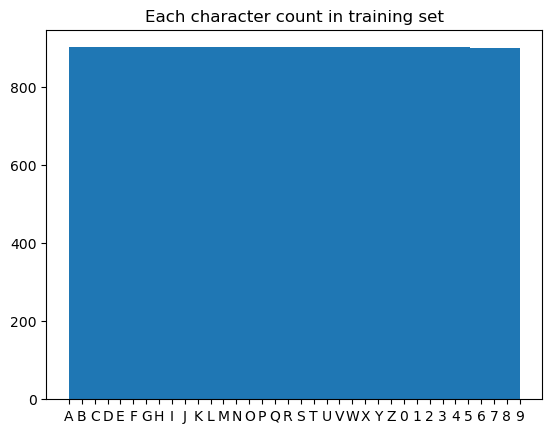

In [12]:
fig, axs = plt.subplots()
axs.hist(np.argmax(Y_train, axis=1), bins=36)
axs.set_title('Each character count in training set')
axs.set_xticks(range(36))
axs.set_xticklabels([c for c in list(ctoi.keys())])

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(40, 30, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(36))
model.add(layers.Softmax())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 26, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 24, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 52224)             0         
                                                                 
 dense (Dense)               (None, 64)                3342400   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4

In [14]:
EPOCHS = 4

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=EPOCHS, 
                    validation_data=(X_valid, Y_valid))


Epoch 1/4
1014/1014 [==============================] - 72s 70ms/step - loss: 0.5587 - accuracy: 0.8627 - val_loss: 0.1352 - val_accuracy: 0.9661
Epoch 2/4
1014/1014 [==============================] - 68s 67ms/step - loss: 0.0909 - accuracy: 0.9724 - val_loss: 0.1055 - val_accuracy: 0.9648
Epoch 3/4
1014/1014 [==============================] - 67s 66ms/step - loss: 0.0659 - accuracy: 0.9799 - val_loss: 0.0714 - val_accuracy: 0.9786
Epoch 4/4
1014/1014 [==============================] - 67s 66ms/step - loss: 0.0531 - accuracy: 0.9834 - val_loss: 0.0489 - val_accuracy: 0.9842


Text(0.5, 1.0, 'Model Accuracy on validation and training data over 4 epochs')

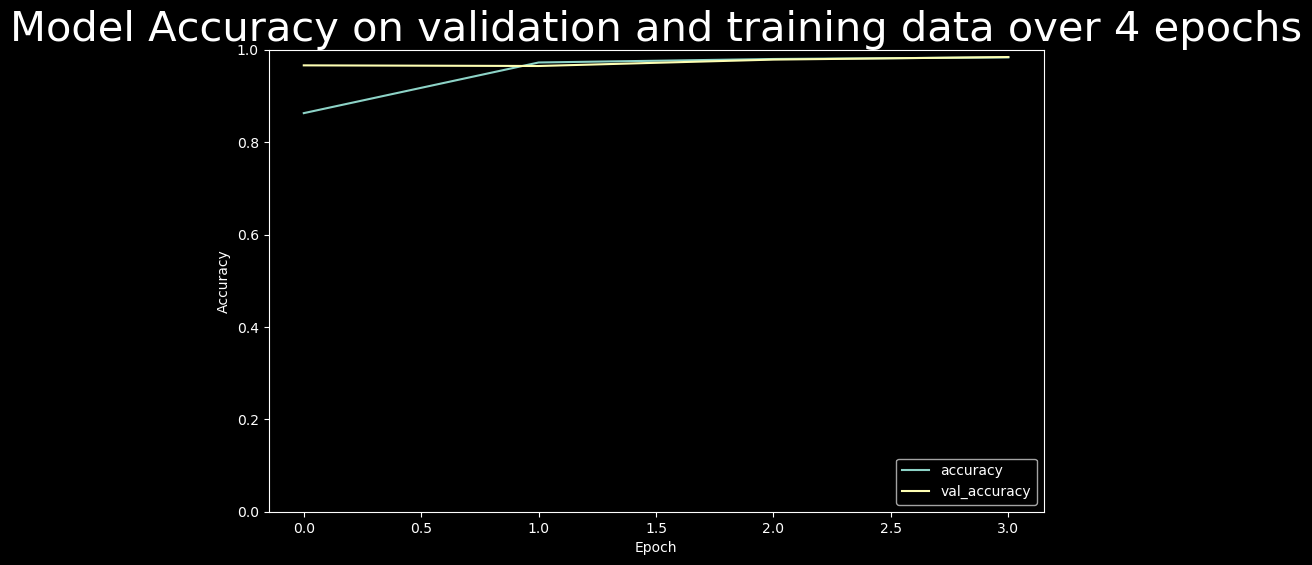

In [15]:

plt.style.use('dark_background')
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')
plt.title(f"Model Accuracy on validation and training data over {EPOCHS} epochs", size=30)

Text(0.5, 0.98, 'Model predictions')

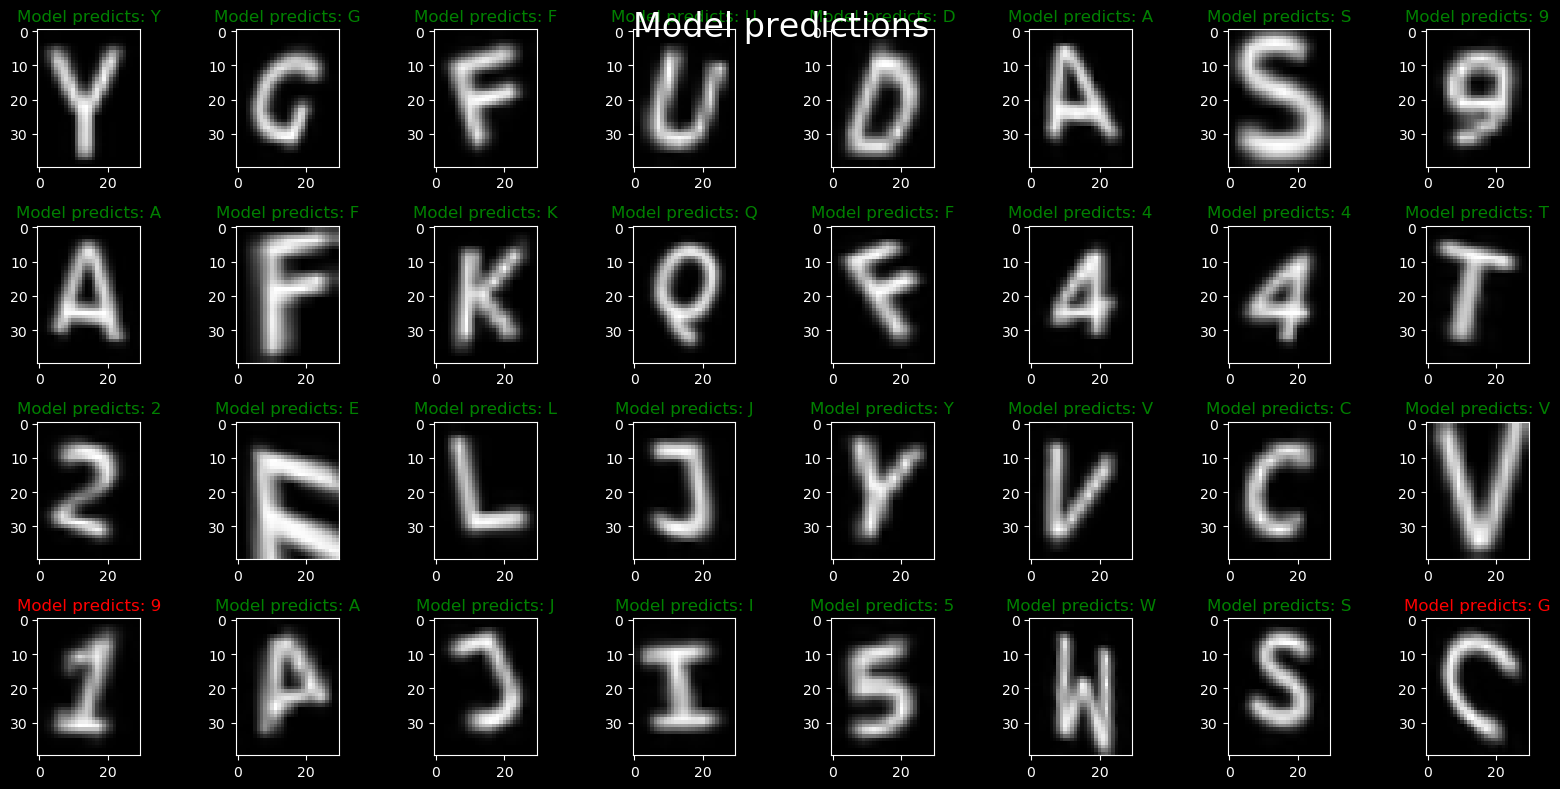

In [20]:

fig, axs = plt.subplots(4,8, figsize=(16,8))
for i in range(32):
    n = np.random.randint(X_valid.shape[0])
    input = tf.expand_dims(tf.expand_dims(X_valid[n], -1), 0)
    label = itoc[np.argmax(Y_valid[n])]
    ypred = str(itoc[np.argmax(model(input))])
    axs[i//8, i%8].imshow(X_valid[n], cmap='gray')
    if label == ypred:
        axs[i//8, i%8].set_title('Model predicts: ' + ypred, color='green')
    else:
        axs[i//8, i%8].set_title('Model predicts: ' + ypred, color='red')
fig.tight_layout()
fig.suptitle('Model predictions', fontsize=24)